# Machine learning pipeline

## Load packages

In [2]:
'''
Machine learning HW 3
Spring 2019
pete rodrigue
'''

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pylab
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from IPython.core.pylabtools import figsize
import random

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
os.getcwd()

'C:\\Users\\edwar.WJM-SONYLAPTOP'

## Set your working directory to the root folder of the repository (ML_spring_2019) on your computer

### You may need to change the path below:

In [4]:
os.chdir("C:\\Users\\edwar.WJM-SONYLAPTOP\\Documents\\GitHub\\ML_spring_2019")

## Define all our functions

In [5]:
def load_and_peek_at_data(path, summary=False):
    '''
    Loads our data and returns a pandas dataframe.
    This function also saves a csv file with descriptive statistics for all
    our variables to our figures folder.
    '''
    separator = '************************\n************************\n\n'
    df = pd.read_csv(path)
    print(separator)
    print('Head of data:')
    print(df.head(5))
    print(separator)
    print('Tail of data:')
    print(df.tail(5))
    print(separator)
    print('column names of data:')
    print(df.columns)
    print(separator)
    print('number of rows of data:')
    print(len(df))
    print(separator)

    if summary:
        print("\n\n\nSummary of data:")
        print(df.describe())
        df.describe().to_csv('exercise two/figures/summary.csv')

    return df


def make_graphs(df, normal_qq_plots=False):
    '''
    Takes our dataframe, fills in missing values with the median,
    and outputs a series of plots:
            - Normal qq plots for each variable
            - Boxplots for each variable
            - Histograms for each variable
        - A correlation plot for all our variables

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    df_temp = df._get_numeric_data()
    fill_missing(df_temp)
    g = sns.heatmap(df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])].corr())
    plt.savefig('exercise two/figures/correlation_plot')
    plt.close()
    for col in df_temp.columns:
        plt.clf()
        mycol = df_temp[col][df_temp[col].notna()]
        print('skew', ' for col ', mycol.name, 'is:', mycol.skew())
        if abs(mycol.skew()) > 10:
            path = "exercise two/figures/" + col + "log_transformed"
            g = sns.distplot(mycol)
            g.set_title(col + " dist, log_transformed")
            g.set(xscale='log')
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + \
                       " normal_qq_plot log trans"
                g = stats.probplot(np.log(df[col]+.0001),
                                   dist="norm", plot=pylab)
                plt.title(col + " normal_qq log transformed")
                plt.savefig(path)
        else:
            path = "exercise two/figures/" + col
            g = sns.distplot(mycol)
            g.set_title(col + " distribution")
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + " normal_qq_plot"
                g = stats.probplot(df[col], dist="norm", plot=pylab)
                plt.title(col + " normal_qq")
                plt.savefig(path)
        plt.clf()
        path = "exercise two/figures/" + col + " boxplot"
        g = sns.boxplot(mycol)
        plt.savefig(path)


def fill_missing(df):
    '''
    Fill missing numerica data in our data frame with the median value of that
    variable. Modifies the dataframe in place. Does not return anything.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    for col in df.columns:
        if df[col].isna().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)


def descretize_var(df, var, num_groups):
    '''
    Takes one of our variables and splits it into discrete groups.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make a
                   categorical variable from
        num_groups (int): the number of groups our discrete variable will have

    Returns: a modified dataframe.
    '''
    labs = list(range(1, num_groups + 1))
    labs = [str(x) for x in labs]
    new_var = var + '_discrete'
    df[new_var] = pd.qcut(df[var], num_groups, labels=labs)

    return df


def make_dummies(df, var):
    '''
    Takes our dataframe and turns a specified variable into a series of
    dummy columns. This function returns the modified dataframe.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make dummies of

    Returns: a modified dataframe.
    '''
    new_var_prefix = "D_" + var

    return pd.concat([df, pd.get_dummies(df[var], prefix=new_var_prefix)],
                     axis=1)

## Models

### Tree

In [6]:
def run_tree_model(x_data, y_data, x_test=None,
                   y_test=None, max_depth=5, outcome_labels=None, threshold=.5, use_test_sets=False):
    '''
    This function takes our data and computes a decision tree model.
    It saves a .dot file you can open in graphviz to see the tree.
    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        max_depth (int): the maximum depth of the tree.
        outcome_labels (list of str): the labels for our predictor variables.
    '''
    mymodel = tree.DecisionTreeClassifier(max_depth=max_depth)
    mymodel.fit(X=x_data, y=y_data)
    
    print("***************Tree model")
#     print("Training set performance:")
    print("*********Threshold:{0}".format(threshold))
#     mypreds = mymodel.predict(x_data)
#     print(metrics.classification_report(y_data, mypreds))

#     tree.export_graphviz(mymodel,
#                          out_file='exercise two/figures/tree.dot',
#                          feature_names=x_data.columns,
#                          class_names=outcome_labels,
#                          filled=True)
    
#     predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
#     predicted_probs['predicted_class'] = 0
#     predicted_probs.loc[predicted_probs[1] >= threshold,
#                             'predicted_class'] = 1
#     cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     print(cm)
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        print('mean of pred class is')
        print(predicted_probs['predicted_class'].mean())
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

### Logit model

In [7]:
def run_logit_model(x_data, y_data, x_test=None, y_test=None, threshold=.5, use_test_sets=False):
    '''
    This function takes our x and y data and a threshold,
    and computes a logistic model. It exports a confusion matrix table.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        threshold (float): the threshold, between 0 and 1, that we'll use to
                           to decide if a given row is predicted to be a
                           positive in the target class or not.
    '''
    mymodel = LogisticRegression()
    mymodel.fit(x_data, y_data)
    
    print('***********Logistic regression')
    print('Training set performance:')
    print("*********Threshold:{0}".format(threshold))
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
#     predicted_probs['predicted_class'] = 0
#     predicted_probs.loc[predicted_probs[1] > threshold, 'predicted_class'] = 1
#     cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
#     print(cm)
#     mypreds = mymodel.predict(x_data)
#     print(metrics.classification_report(y_data, mypreds))

#     score = (cm[0][0] + cm[1][1]) / sum(sum(cm))

#     plt.clf()
#     g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,
#                     square=True, cmap='Blues_r')
#     plt.ylabel('Actual label')
#     plt.xlabel('Predicted label')
#     all_sample_title = 'Using {0} threshold, score is: {1}'.format(
#                                                             threshold, score)
#     plt.title(all_sample_title, size=15)
#     plt.savefig('exercise two/figures/logistic_confusion_matrix')
#     plt.clf()
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm



### K-Nearest Neighbor

In [8]:
def run_knn_model(x_data, y_data, x_test=None, y_test=None, num_n=2, threshold=.5, use_test_sets=False):
    '''
    This function takes our x and y data and a threshold,
    and computes a knn model. It exports a confusion matrix table.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        threshold (float): probability threshold needed to call prediction positive
        num_n (int): the number of neighbors
    '''
    mymodel = KNeighborsClassifier(n_neighbors=num_n)
    mymodel.fit(x_data, y_data)
    
    print('************KNN')
    print('Training set performance:')
    print('confusion matrix')
    print('|T neg, F pos|\n|F neg, T pos|')
#     predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
#     predicted_probs['predicted_class'] = 0
#     predicted_probs.loc[predicted_probs[1] > threshold, 'predicted_class'] = 1
#     cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
#     print(cm)
#     mypreds = mymodel.predict(x_data)
#     print(metrics.classification_report(y_data, mypreds))

#     score = (cm[0][0] + cm[1][1]) / sum(sum(cm))

#     plt.clf()
#     g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,
#                     square=True, cmap='Blues_r')
#     plt.ylabel('Actual label')
#     plt.xlabel('Predicted label')
#     all_sample_title = 'Using {0} threshold and {1} neighbors, score is: {2}'.format(
#                                                             threshold, num_n, round(score, 2))
#     plt.title(all_sample_title, size=15)
#     plt.savefig('exercise two/figures/knn_confusion_matrix')
#     plt.clf()
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

   

### SVM

In [9]:
# SVM
def run_svm_model(x_data_scaled, y_data, x_test=None,
                  y_test=None, kernel='linear', threshold=.5, use_test_sets=False):
    '''
    Runs and SVM model on your data
    Note: this will run much faster if you scale your x data first
    '''
    mymodel = svm.SVC(kernel='linear', probability=True)
    mymodel.fit(x_data_scaled,
                    y_data)  
    mypreds = mymodel.predict(x_data_scaled)
#     print('*************SVM')
#     print('Training set performance:')
#     print("*********Threshold:{0}".format(threshold))
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     cm = metrics.confusion_matrix(y_data, mypreds)
#     print(cm)  
#     mypreds = mymodel.predict(x_data_scaled)
#     print(metrics.classification_report(y_data, mypreds))
    
#     print('Of all the people we labeled positive, ', 
#               round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
#               "% were actually positive, while ",
#               round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
#               "% were actually negative\n")
#     print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
#     print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
#              '% of all the actually positive people positive.\n',
#              'Which means we did not label as positive ',
#               100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
#               '% of all people who are actually positive.\n\n')
    
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data_scaled))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

### Random Forests

In [10]:
# Random Forest
def run_forest(x_data, y_data, x_test=None, y_test=None,
               my_n_estimators=10, my_max_depth=5, threshold=.5, use_test_sets=False):
    '''
    Runs a random forest model
    Inputs:
        x_data (pd dataframe) : our predictor data
        y_data (pd dataframe) : our outcome data
        n_estimators (int): the number of trees in our forest
        max_depth (int): the max number of levels in our trees
    '''
    mymodel = RandomForestClassifier(n_estimators=my_n_estimators, max_depth=my_max_depth)
    mymodel.fit(x_data, y_data)
    
#     mypreds = mymodel.predict(x_data)
#     print('***************Random forest')
#     print('Training set performance:')
#     print("*********Threshold:{0}".format(threshold))
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     cm = metrics.confusion_matrix(y_data, mypreds)
#     print(cm)  
#     mypreds = mymodel.predict(x_data)
#     print(metrics.classification_report(y_data, mypreds))
    
#     print('Of all the people we labeled positive, ', 
#               round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
#               "% were actually positive, while ",
#               round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
#               "% were actually negative\n")
#     print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
#     print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
#              '% of all the actually positive people positive.\n',
#              'Which means we did not label as positive ',
#               100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
#               '% of all people who are actually positive.\n\n')
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

### Boosting

In [11]:
# Boosting
def run_boosted_model(x_data, y_data, x_test=None, y_test=None,
                      my_max_depth=5, my_n_estimators=10, threshold=.5, use_test_sets=False):
    '''
    Run a boosted decision tree model
    '''
    mymodel = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=5),
                             algorithm="SAMME",
                             n_estimators=10)
    mymodel.fit(x_data, y_data)
#     mypreds = mymodel.predict(x_data)
#     print('**************Boosting')
#     print('Training set performance:')
#     print("*********Threshold:{0}".format(threshold))
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     cm = metrics.confusion_matrix(y_data, mypreds)
#     print(cm) 
#     mypreds = mymodel.predict(x_data)
#     print(metrics.classification_report(y_data, mypreds))
    
#     print('Of all the people we labeled positive, ', 
#               round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
#               "% were actually positive, while ",
#               round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
#               "% were actually negative\n")
#     print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
#     print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
#              '% of all the actually positive people positive.\n',
#              'Which means we did not label as positive ',
#               round(100 - cm[1][1] / sum(cm[1])*100 , 2), 
#               '% of all people who are actually positive.\n\n')

    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

### Bagging

In [12]:
# Bagging
def run_bagging_model(x_data, y_data, x_test=None, y_test=None, threshold=.5, use_test_sets=False):
    '''
    Runs a bagging model
    '''
    mymodel = BaggingClassifier(KNeighborsClassifier(n_neighbors=16),
                                 max_samples=100, max_features=1000)
    mymodel.fit(x_data, y_data)
#     mypreds = mymodel.predict(x_data)
#     print('****************Bagging')
#     print('Training set performance:')
#     print("*********Threshold:{0}".format(threshold))
#     print('confusion matrix')
#     print('|T neg, F pos|\n|F neg, T pos|')
#     cm = metrics.confusion_matrix(y_data, mypreds)
#     print(cm)  
#     print('Of all the people we labeled positive, ', 
#               round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
#               "% were actually positive, while ",
#               round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
#               "% were actually negative\n")
#     print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
#     print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
#              '% of all the actually positive people positive.\n',
#              'Which means we did not label as positive ',
#               100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
#               '% of all people who are actually positive.\n\n')
#     print(metrics.classification_report(y_data, mypreds))
    
    if use_test_sets:
        print('Returning test set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_test))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_test, predicted_probs['predicted_class'])
        
        return cm
    
    else:
        print('Returning training set performance:')
        predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])    
        
        return cm

### Looping through models to compare performance

In [13]:
def compare_models(x_data=None, x_data_scaled=None, y_data=None,
                   x_test=None, x_test_scaled=None, y_test=None, use_test_data=False,
                   run_bagging=False, run_boosted=False, run_a_forest=False,
                   run_svm=False, run_knn=False, run_logit=False, run_tree=False,
                   mythresholds=[.5],
                   my_max_depth=5, my_n_estimators=10,
                   num_n=8,
                   outcome_labels=None,
                  mykernel='linear'):    
    '''
    Compare all our models
    '''
    model = []
    fpr = []
    tpr = []
    precision = []
    current_threshold = []
    if run_bagging:
        for t in mythresholds:
            cm = run_bagging_model(x_data, y_data, threshold=t, x_test=x_test,
                                   y_test=y_test, use_test_sets=use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('bagging')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_boosted:
        for t in mythresholds:
            cm = run_boosted_model(x_data=x_data, y_data=y_data,
                              my_max_depth=my_max_depth, my_n_estimators=my_n_estimators, threshold=t,
                                  x_test=x_test, y_test=y_test, use_test_sets=use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('boosted')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_a_forest:
        for t in mythresholds:
            cm = run_forest(x_data, y_data, x_test, y_test,
                        my_n_estimators, my_max_depth, t,
                                use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('forest')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_svm:
        for t in mythresholds:
#            def run_svm_model(x_data_scaled, y_data, x_test=None,
#                   y_test=None, kernel='linear', threshold=.5, use_test_sets=False):
            cm = run_svm_model(x_data_scaled, y_data, threshold=t,
                              x_test=x_test_scaled, y_test=y_test, use_test_sets=use_test_data, kernel=mykernel)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('svm')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_knn:
        for t in mythresholds:
            cm = run_knn_model(x_data, y_data, num_n=num_n, threshold=t,
                              x_test=x_test, y_test=y_test, use_test_sets=use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('knn')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_logit:
        for t in mythresholds:
            cm = run_logit_model(x_data, y_data=y_data, threshold=t,
                                x_test=x_test, y_test=y_test, use_test_sets=use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('logit')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    if run_tree:
        for t in mythresholds:
            cm = run_tree_model(x_data,
                       y_data=y_data,
                       max_depth=my_max_depth,
                       outcome_labels=outcome_labels, threshold=t,
                               x_test=x_test, y_test=y_test, use_test_sets=use_test_data)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('tree')
            current_threshold.append(t)
            precision.append(cm[1][1] / (cm[1][1] + cm[0][1]))
            print('\n')
    
    rows_to_add = len(current_threshold)
    to_plot = pd.DataFrame({'model': model + ['baseline'] * rows_to_add, 
                            'tpr': tpr + fpr[0:rows_to_add],
                            'fpr': fpr + fpr[0:rows_to_add],
                            'precision': precision + [None] * rows_to_add,
                            'threshold': current_threshold + [None] * rows_to_add,
                           })
    print('\n\n')
    for m in to_plot['model'].unique():
        auc = -1*np.trapz(y=to_plot.loc[to_plot['model'] == m, 'tpr'],
                      x=to_plot.loc[to_plot['model'] == m, 'fpr'])
        print('AUC for ', m, ' is', auc)
        
    print('\n\nTable of results:')
    print(to_plot)
    random_number = random.randint(1,100000)
    print(random_number)
    to_plot.to_csv(str(random_number) + ".csv")
    plt.clf()
    sns.lineplot(x=to_plot['fpr'],
                 y=to_plot['tpr'],
                 hue=to_plot['model'])
    
    

## Function to split data into test and training data

In [14]:
def split_using_date(data, train_start_date, train_end_date):
    '''
    Splits our data into test and training sets using a date the user provides
    '''
    train = projects.loc[projects['date_posted'].between(
                                                    train_start_date,
                                                    train_end_date,
                                                    inclusive=True), :]
    test = projects.loc[projects['date_posted'].between(
                                                    train_end_date,
                                                    '2014-01-01',
                                                    inclusive=False), :]
    
    return [train, test]

# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.


# Working with the credit data

## Load our data

In [ ]:
# 1. Read/Load Data
df = load_and_peek_at_data('exercise two/credit-data.csv', summary=True)

## Explore data
See "ML_spring_2019\exercise two\figures" for all the figures output by this function.

In [ ]:
# 2. Explore Data
make_graphs(df, normal_qq_plots=False)

## Clean and preprocess data

In [ ]:
# 3. Pre-Process and Clean Data
fill_missing(df)
x_data = df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])]
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_data)
x_data_scaled = scaling.transform(x_data)
y_data = df['SeriousDlqin2yrs']

## Generate Features/Predictors

In [ ]:
# 4. Generate Features/Predictors

# one function that can discretize a continuous variable
# df = descretize_var(df, 'MonthlyIncome', 3)

# one function that can take a categorical
# variable and create binary/dummy variables from it.
# make_dummies(df, 'MonthlyIncome_discrete')

## Build and evaluate classifiers

In [ ]:
# Decision tree
run_tree_model(x_data,
               y_data=df['SeriousDlqin2yrs'],
               max_depth=5,
               outcome_labels=['Not Delinquent', 'Delinquent'], threshold=.5)

In [ ]:
# Logit
run_logit_model(x_data,
                y_data=df['SeriousDlqin2yrs'], threshold=.25)

In [ ]:
# Logit with different thresholds
# logit_try_diff_thresholds(x_data,
#                 y_data=df['SeriousDlqin2yrs'], step=.1) 

In [ ]:
# KNN
run_knn_model(x_data,
                df['SeriousDlqin2yrs'],
              num_n=8, threshold=.5)

In [ ]:
# KNN with different thresholds
# knn_try_diff_thresholds(x_data,
#                 df['SeriousDlqin2yrs'],
#               num_n=16, step=.1, details=True)

In [ ]:
# SVM
run_svm_model(x_data_scaled, df['SeriousDlqin2yrs'], threshold=.25, kernel='linear')

In [ ]:
# Random Forest
run_forest(x_data=x_data, y_data=df['SeriousDlqin2yrs'],
                my_n_estimators=10, my_max_depth=5, threshold=.25)

In [ ]:
# Bagging
run_bagging_model(x_data, y_data, threshold=.25)

In [ ]:
# Boosting
run_boosted_model(x_data=x_data, y_data=y_data, my_max_depth=5, my_n_estimators=10, threshold=.5)

In [ ]:
# compare models
compare_models(x_data, x_data_scaled, y_data,
                   run_bagging=True, run_boosted=True, run_a_forest=True,
                   run_svm=False, run_knn=False, run_logit=True, run_tree=True,
                   mythresholds=[.5],
                   my_max_depth=5, my_n_estimators=10,
                   num_n=8,
                   outcome_labels=None,
                   x_test=None, y_test=None, use_test_sets=False)

# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.
# .___..___..___..___..___..___..___..___..___..___..___..___.


# Working with the project grant database

In [15]:
projects = load_and_peek_at_data('exercise two/projects_2012_2013.csv', summary=True)

************************
************************


Head of data:
                          projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0   

In [16]:
# convert variables to dates
projects['date_posted'] = pd.to_datetime(projects['date_posted'])
projects['datefullyfunded'] = pd.to_datetime(projects['datefullyfunded'])

In [17]:
projects.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded'],
      dtype='object')

In [18]:
# make dummy vars
cat_vars = ['primary_focus_subject', 'secondary_focus_area', 'secondary_focus_subject', 'school_city', 'school_metro', 'school_state', 'school_charter', 'school_magnet',
           'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level',
           'eligible_double_your_impact_match']
for var in cat_vars:
    projects = make_dummies(projects, var)

In [19]:
# make dummy outcome var
projects['60_day_outcome'] = (projects['datefullyfunded'] -
                              projects['date_posted']) > pd.Timedelta('60 days')

In [20]:
projects[['60_day_outcome', 'datefullyfunded', 'date_posted']].head()

,60_day_outcome,datefullyfunded,date_posted
0,False,2013-05-02,2013-04-14
1,False,2012-04-18,2012-04-07
2,True,2012-04-15,2012-01-30
3,False,2012-12-05,2012-10-11
4,True,2013-03-25,2013-01-08


In [21]:
# take a subset of our features
new_cat_vars = [col for col in projects if col.startswith('D_')]
vars_to_keep = new_cat_vars + ['date_posted', 'students_reached',
                               'total_price_including_optional_support', '60_day_outcome']
projects = projects[vars_to_keep]

In [22]:
# fill nan values
median_val = projects['total_price_including_optional_support'].median()
projects['total_price_including_optional_support'].fillna(median_val, inplace=True)
projects['total_price_including_optional_support'].isna().any()

False

In [23]:
median_val = projects['students_reached'].median()
projects['students_reached'].fillna(median_val, inplace=True)
projects.loc[projects['students_reached'].isna()==True, 'students_reached'] = median_val
projects['students_reached'].isna().any()

False

In [24]:
# So we can see all our graphs
figsize(14, 7)

## Set up our 3 training sets and initialize the first one

In [25]:
test_set_ranges = [('2012-01-01', '2012-07-01'), ('2012-07-02', '2012-12-31'), ('2013-01-01', '2013-07-01')]

In [49]:


date_subset = test_set_ranges[0]
train, test = split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1])
print('training start and end dates are ', date_subset)
print('training data dimensions:')
print(train.shape)

x = train.drop(['60_day_outcome', 'date_posted'], axis=1)
x_t = test.drop(['60_day_outcome', 'date_posted'], axis=1)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y = train['60_day_outcome']
y_t = test['60_day_outcome']

print('mean of 60 day outcome in training set:')
print(round(y.mean(), 2), '\n\n\n')


training start and end dates are  ('2012-01-01', '2012-07-01')
training data dimensions:
(26617, 6101)
mean of 60 day outcome in training set:
0.31 





### Doing a trial example with only 100 rows to make sure things work:

Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars


Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars




************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.01
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.02
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.05
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.1
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.2
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:0.3
Returning test set performance:


***********Logistic regression
Training set performance:
*********Threshold:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


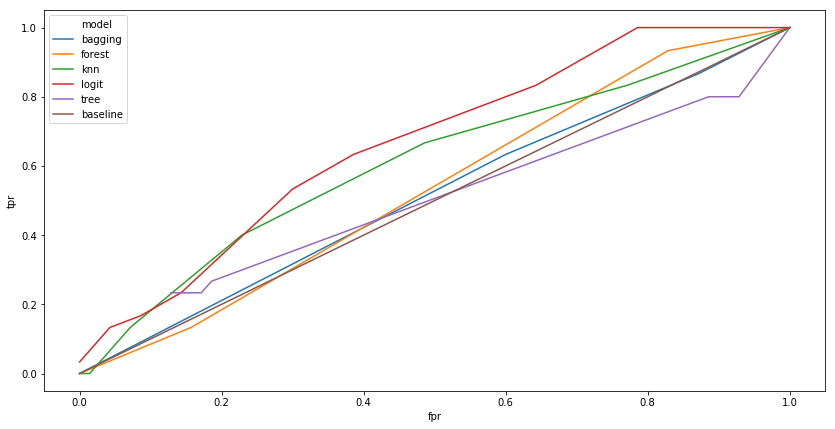

In [52]:
num_rows = 100

compare_models(x_data=x[:num_rows], x_data_scaled=x_scaled[:num_rows], y_data=y[:num_rows],
               x_test=x_t[:num_rows], x_test_scaled=x_t_scaled[:num_rows],
               y_test=y_t[:num_rows], use_test_data=True,
               #run_svm=True,
               run_tree=True,
               run_boosted=False, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
                mythresholds=[0, .01, .02, .05, .1, .2, .3, .5, .6, .7, .9, 1])


## Run our first set, with training set = first 6 months of data

Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KN

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


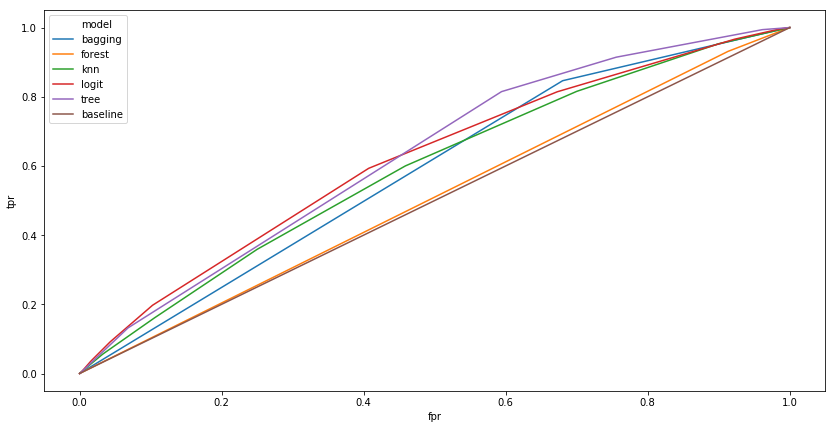

In [53]:
compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               #run_svm=True,
               run_tree=True,
               run_boosted=False, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
                mythresholds=[0, .01, .02, .05, .1, .2, .3, .5, .6, .7, .9, 1])


## Run our second set, with training set = first 12 months of data

training start and end dates are  ('2012-07-02', '2012-12-31')
training data dimensions:
(32607, 6101)



mean of 60 day outcome in training set:
0.26 

Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KN

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


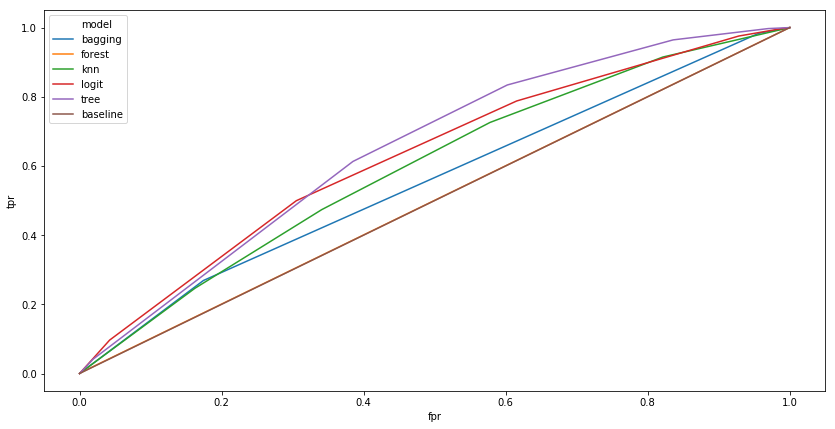

In [24]:
date_subset = test_set_ranges[1]
train, test = split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1])
print('training start and end dates are ', date_subset)
print('training data dimensions:')
print(train.shape)
print('\n\n')

x = train.drop(['60_day_outcome', 'date_posted'], axis=1)
x_t = test.drop(['60_day_outcome', 'date_posted'], axis=1)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y = train['60_day_outcome']
y_t = test['60_day_outcome']

print('mean of 60 day outcome in training set:')
print(round(y.mean(), 2), '\n')

compare_models(x_data=x, y_data=y, x_test=x_t, y_test=y_t, use_test_data=True,
               run_tree=True,
               run_boosted=False, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
                mythresholds=[0, .01, .02, .05, .1, .2, .3, .5, 1])

## Run our third set, with training set = first 18 months of data

training start and end dates are  ('2013-01-01', '2013-07-01')
training data dimensions:
(21707, 6101)
mean of 60 day outcome in training set:
0.32 

Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




Returning test set performance:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in longlong_scalars




************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KNN
Training set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
Returning test set performance:


************KN

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


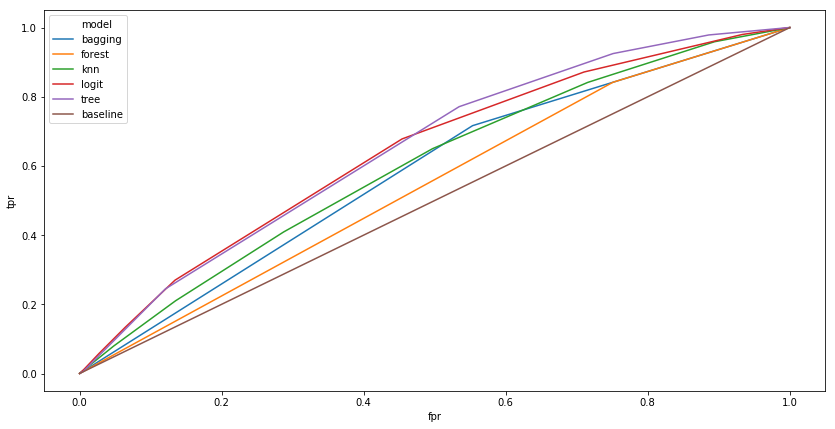

In [26]:
date_subset = test_set_ranges[2]
train, test = split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1])
print('training start and end dates are ', date_subset)
print('training data dimensions:')
print(train.shape)

x = train.drop(['60_day_outcome', 'date_posted'], axis=1)
x_t = test.drop(['60_day_outcome', 'date_posted'], axis=1)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y = train['60_day_outcome']
y_t = test['60_day_outcome']

print('mean of 60 day outcome in training set:')
print(round(y.mean(), 2), '\n')

compare_models(x_data=x, y_data=y, x_test=x_t, y_test=y_t, use_test_data=True,
               run_tree=True,
               run_boosted=False, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, .01, .02, .05, .1, .2, .3, .5, .6, .7, .9, 1])